# **Waste Detection Using YoloV8**

## Import Required Packages

In [1]:
import torch
from IPython.display import Image, clear_output
import gdown

## Install Dependencies

In [2]:
# Check the GPU
!nvidia-smi

Sun Nov 19 02:17:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 16062, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 16062 (delta 1), reused 2 (delta 0), pack-reused 16056
Receiving objects: 100% (16062/16062), 14.68 MiB | 24.44 MiB/s, done.
Resolving deltas: 100% (11029/11029), done.


In [4]:
%cd yolov5

/content/yolov5


In [5]:
%pwd

'/content/yolov5'

In [6]:
# Install YOLOv5 dependencies
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.2/645.2 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.


## Load Custom Dataset

In [7]:
%cd /content
%pwd

/content


'/content'

In [8]:
url = 'https://drive.google.com/file/d/1YBtZfdYtJ341DJ51JJFA8iOrHC4A9b22/view?usp=sharing'
file_id = url.split('/')[-2]
prefix = 'https://drive.google.com/uc?/export=download&id='
gdown.download(prefix+file_id)
print('Data Downloaded from GDrive')

Downloading...
From: https://drive.google.com/uc?/export=download&id=1YBtZfdYtJ341DJ51JJFA8iOrHC4A9b22
To: /content/waste_detection.zip
100%|██████████| 168M/168M [00:01<00:00, 108MB/s]

Data Downloaded from GDrive


In [9]:
# Unzip the dataset and remove the ZIP file
!unzip waste_detection.zip
!rm -rf waste_detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/images/000038_jpg.rf.a3eb8598f375cc5778157dbe9482fd30.jpg  
  inflating: train/images/000038_jpg.rf.a9be5c02798224dd3a7ab20fdb30f488.jpg  
  inflating: train/images/000039_JPG.rf.2813251ec488e2b1503edc7cb9c8b250.jpg  
  inflating: train/images/000039_jpg.rf.0b17bf0dd7b452795b58d62c88e7a3a9.jpg  
  inflating: train/images/000039_jpg.rf.102e5db374f318a70dfb5503807d1344.jpg  
  inflating: train/images/000039_jpg.rf.631319ddd39e1f03852f2f674c4f8007.jpg  
  inflating: train/images/000040_JPG.rf.3d61585be3a8e02c1311d787d6ee0a3a.jpg  
  inflating: train/images/000040_JPG.rf.9c5c14992771423138934c6ae0c697a0.jpg  
  inflating: train/images/000040_JPG.rf.f988f3dd2257ce2d47997d2ade0c4bc8.jpg  
  inflating: train/images/000040_jpg.rf.4ea654f05305636850a9d1867586d14d.jpg  
  inflating: train/images/000040_jpg.rf.b1125b0d20100d5e72ddfc7a35b1e14e.jpg  
  inflating: train/images/000040_jpg.rf.b816789f73ff6c347aacc9f8d917b736.jpg  
 

In [10]:
# Read the data YAML file
%cat data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 5
names: ['Glass', 'Metal', 'Paper', 'Plastic', 'Waste']


## Define Model Configuration and Architecture

In [11]:
# Define number of classes based on YAML
import yaml
with open('data.yaml', 'r') as data:
  num_classes = str(yaml.safe_load(data)['nc'])

In [12]:
num_classes

'5'

In [13]:
# We will use yolov5s model
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

In [14]:
# Create Magic Function, to create a Custom File
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
  with open(line, 'w') as f:
    f.write(cell.format(**globals()))

In [15]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml


# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

## Train Custom YOLOv5 Detector

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [16]:
## Train Custom YOLOv5 Detector
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 50 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results --cache

/content/yolov5
2023-11-19 02:17:49.238064: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 02:17:49.238126: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 02:17:49.238169: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optim

## Evaluate Custom yoloV5 Detector Performance

In [ ]:
# Start Tensorboard
%load_ext tensorboard
%tensorboard --logdir runs

Augemnted Training Data


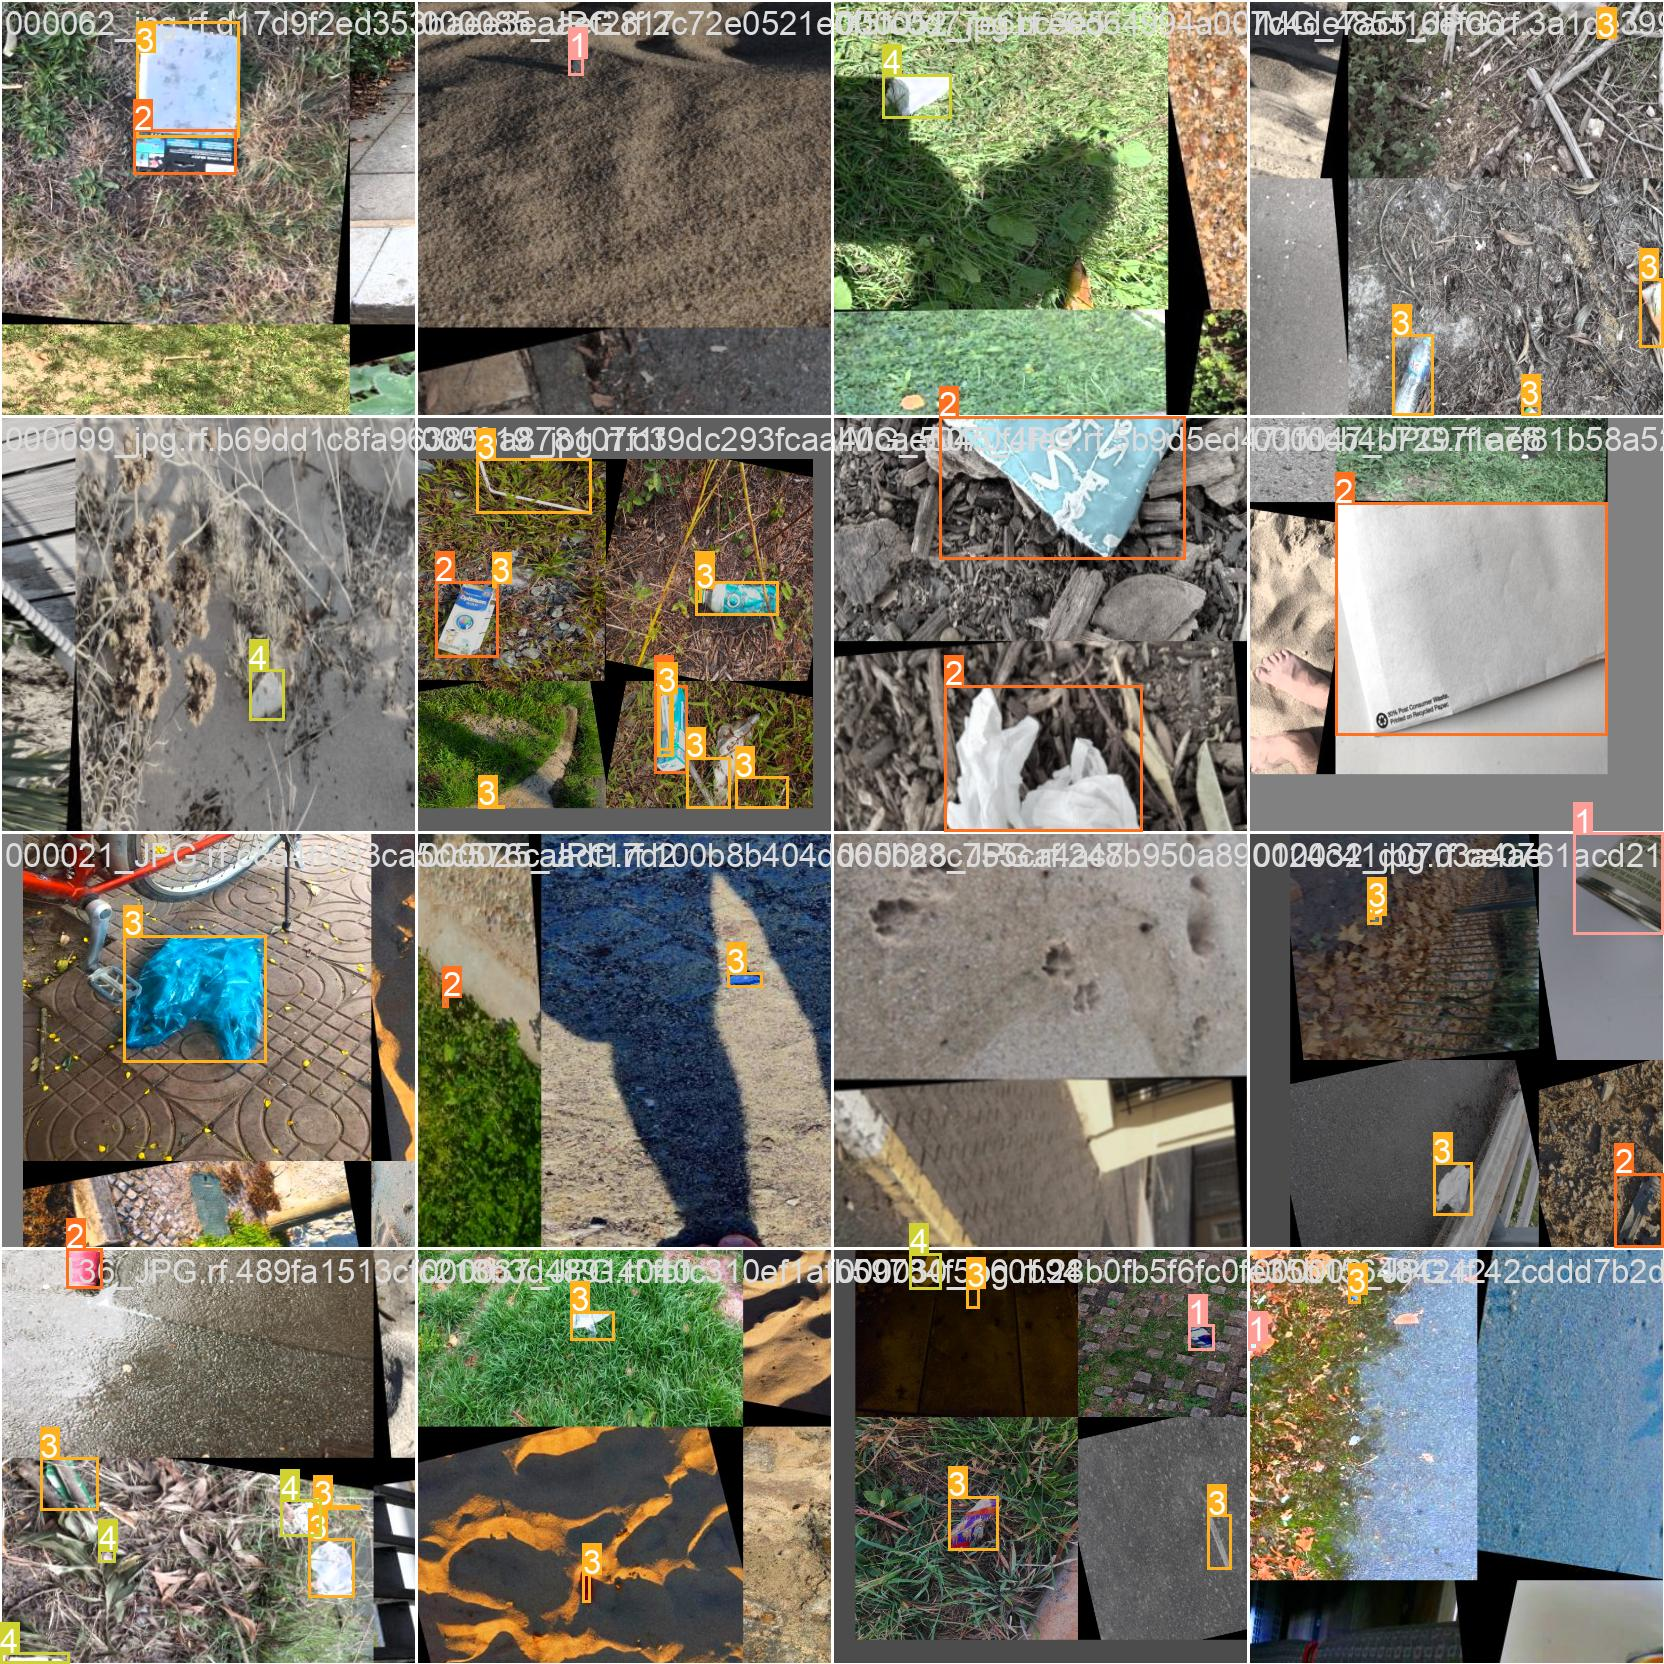

In [21]:
# Augmented Trainind Example
print('Augemnted Training Data')
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=1200)

## Detect wastes using the best train weight

In [23]:
# List of trained weights
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [24]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.5 --source ../valid/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../valid/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-242-gb378d10 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7257306 parameters, 0 gradients
image 1/580 /content/valid/images/000000_JPG.rf.17a10718437ed7fe40246f83ba72f953.jpg: 416x416 1 Paper, 8.0ms
image 2/580 /content/valid/images/000000_JPG.rf.9affb8b6812fff71ade11006517eea22.jpg: 416x416 (no detections), 8.0ms
image 3/580 /content/valid/images/000000_jpg.rf.54eb375df88fa24ea5fa738d00142d69.jpg:

In [25]:
%pwd

'/content/yolov5'

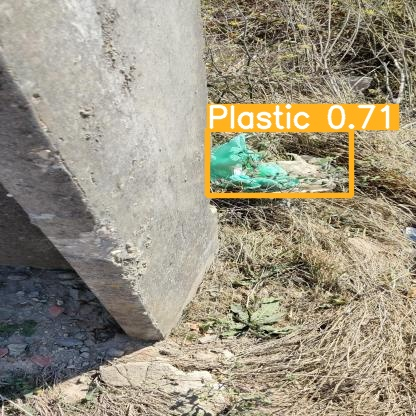

In [32]:
# Object Detection Result
Image(filename='/content/yolov5/runs/detect/exp/000006_jpg.rf.3e12491b304e5772b179c69fc4c2deb0.jpg')

## Export Trained Weights For Further Inference

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [37]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/MyDrive/DataScience/DL/Waste_Detection_Using_YoloV5/model